In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import joblib
import matplotlib.pyplot as plt
import os

In [10]:
# Load data
df = pd.read_csv(r'./data/processed-data.csv')

In [11]:
# --- Feature engineering (make sure you run this before train/test split) ---
df['lat_diff'] = df['latitude_2'] - df['latitude_1']
df['lon_diff'] = df['longitude_2'] - df['longitude_1']
df['same_state'] = (df['state_1'] == df['state_2']).astype(int)
df['route'] = df['airport_iata_1'] + "-" + df['airport_iata_2']
df['distance_bin'] = pd.cut(df['nsmiles'],
                            bins=[0, 500, 1500, 3000, 6000],
                            labels=['short', 'medium', 'long', 'ultra'])

In [12]:
drop_cols = ['passengers', 'fare_lg', 'fare_low', 'large_ms', 'lf_ms']
df = df.drop(columns=drop_cols)

In [13]:
y = df['fare']
X = df.drop(columns=['fare'])

In [14]:
# --- Select usable features ---
usable_features = [
    'year', 'quarter', 'season', 
    'airport_iata_1', 'airport_iata_2',
    'state_1', 'state_2',
    'latitude_1', 'longitude_1',
    'latitude_2', 'longitude_2',
    'nsmiles',
    'lat_diff', 'lon_diff', 'same_state', 'route', 'distance_bin'
]
X = df[usable_features]

In [15]:
# Define categorical and numerical features
cat_features = ['year', 'quarter', 'season', 'airport_iata_1', 'airport_iata_2',
                'state_1', 'state_2', 'route', 'distance_bin']
num_features = ['latitude_1', 'longitude_1', 'latitude_2', 'longitude_2',
                'nsmiles', 'lat_diff', 'lon_diff', 'same_state']

In [ ]:
# Convert categorical features to string type (helps CatBoost detect them correctly)
X = X.copy()  

for col in cat_features:
    X[col] = X[col].astype(str)

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
# Evaluation function for regression performance
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Avoid division by zero for MAPE
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

    print(f"\n{name} Performance:")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.2f}")
    print(f"  MAPE: {mape:.2f}%")

In [ ]:
### === CatBoost Model === ###
# Since CatBoost handles categorical features natively,
# we do not include a OneHotEncoder here.
catboost_pipeline = Pipeline(steps=[
    ('regressor', CatBoostRegressor(
         iterations=100,           # analogous to n_estimators
         learning_rate=0.1,
         depth=6,                  # analogous to max_depth
         random_seed=42,
         cat_features=cat_features,
         verbose=0                 # suppress verbose output during training
    ))
])

catboost_pipeline.fit(X_train, y_train)
y_pred_cb = catboost_pipeline.predict(X_test)

In [21]:
evaluate_model("CatBoost", y_test, y_pred_cb)


CatBoost Performance:
  MSE : 2881.52
  RMSE: 53.68
  MAE : 34.51
  R²  : 0.56
  MAPE: 16.70%


In [22]:
# Hyperparameter tuning with RandomizedSearchCV
param_grid = {
    'regressor__iterations': [100, 200],
    'regressor__depth': [4, 6, 8],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
}

search = RandomizedSearchCV(
    catboost_pipeline,
    param_distributions=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    n_jobs=1,    # Running on a single job
    verbose=2,
    random_state=42
)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__depth=4, regressor__iterations=100, regressor__learning_rate=0.01; total time=   9.4s
[CV] END regressor__depth=4, regressor__iterations=100, regressor__learning_rate=0.01; total time=   9.6s
[CV] END regressor__depth=4, regressor__iterations=100, regressor__learning_rate=0.01; total time=  10.0s
[CV] END regressor__depth=4, regressor__iterations=100, regressor__learning_rate=0.1; total time=   9.9s
[CV] END regressor__depth=4, regressor__iterations=100, regressor__learning_rate=0.1; total time=  10.0s
[CV] END regressor__depth=4, regressor__iterations=100, regressor__learning_rate=0.1; total time=  10.8s
[CV] END regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.3; total time=  14.2s
[CV] END regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.3; total time=  14.6s
[CV] END regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.3; total time

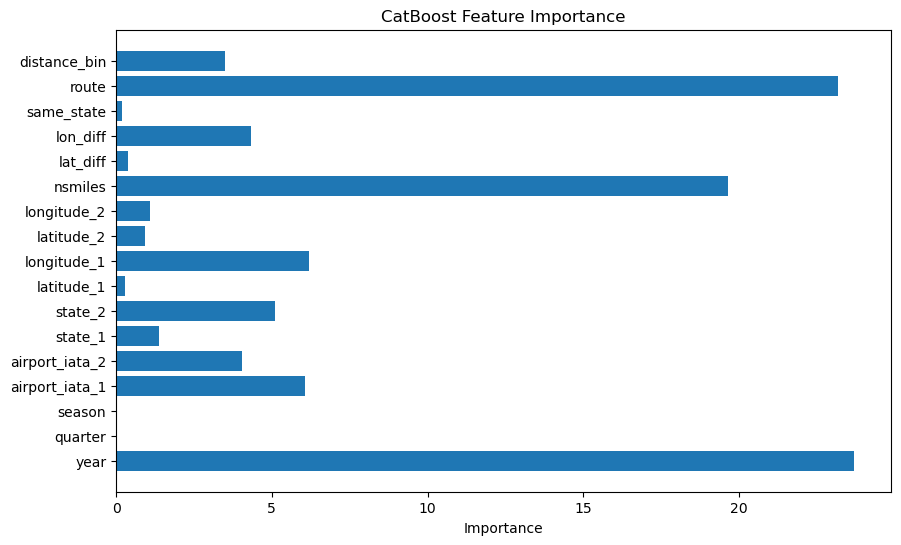

In [23]:
# Plot feature importance from the CatBoost model
# Access the trained regressor from the pipeline
cat_model = catboost_pipeline.named_steps['regressor']
feature_importances = cat_model.get_feature_importance()

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importances)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

In [24]:
# Create a new model using the best hyperparameters from tuning
best_cat_pipeline = Pipeline(steps=[
    ('regressor', CatBoostRegressor(
        iterations=search.best_params_['regressor__iterations'],
        depth=search.best_params_['regressor__depth'],
        learning_rate=search.best_params_['regressor__learning_rate'],
        random_seed=42,
        cat_features=cat_features,
        verbose=0
    ))
])

best_cat_pipeline.fit(X_train, y_train)
y_pred_best = best_cat_pipeline.predict(X_test)


In [25]:
evaluate_model("Tuned CatBoost", y_test, y_pred_best)



Tuned CatBoost Performance:
  MSE : 2228.27
  RMSE: 47.20
  MAE : 28.00
  R²  : 0.66
  MAPE: 13.33%


In [26]:
# --- Save the model for your web app ---
joblib.dump(best_cat_pipeline, "catboost_airfare_model.pkl")

['catboost_airfare_model.pkl']